In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [17]:
# read_summariztion files from either synthpop or populationsim
# summarization files should have control , result and difference columns by HH and/ pop attributes
syn = "popsim"
region = "oakland"
geo = "BLKGRP"
sumfile = 'output/summary_BLKGRP.csv'

In [ ]:
dfs = pd.read_csv(sumfile, index_col = 'geography')
flds = [x.replace('_control', '') for x in dfs.columns.values if x.find('_control') >=0 ]
controls = [ x + '_control' for x in flds]
diffs = [ x + '_diff' for x in flds]
pct_diffs = [ x + '_pct_diff' for x in flds]

In [ ]:
for fld in flds:
    dfs[fld + '_pct_diff'] = dfs[fld + '_diff'] / dfs[fld + '_control'] * 100.0
dfs = dfs.replace([np.inf, -np.inf], np.nan)
dfs.fillna(0, inplace=True)

In [ ]:
dfp = pd.DataFrame(data=[dfs[pct_diffs].mean(), dfs[pct_diffs].std(), dfs[pct_diffs].min(), dfs[pct_diffs].max()]).T
dfp.columns = ['mean', 'std', 'min', 'max']
dfp = dfp.sort_index(ascending=True, axis=0)

In [ ]:
dfp.head(2)

## Error bar chart for synthsized geographies 

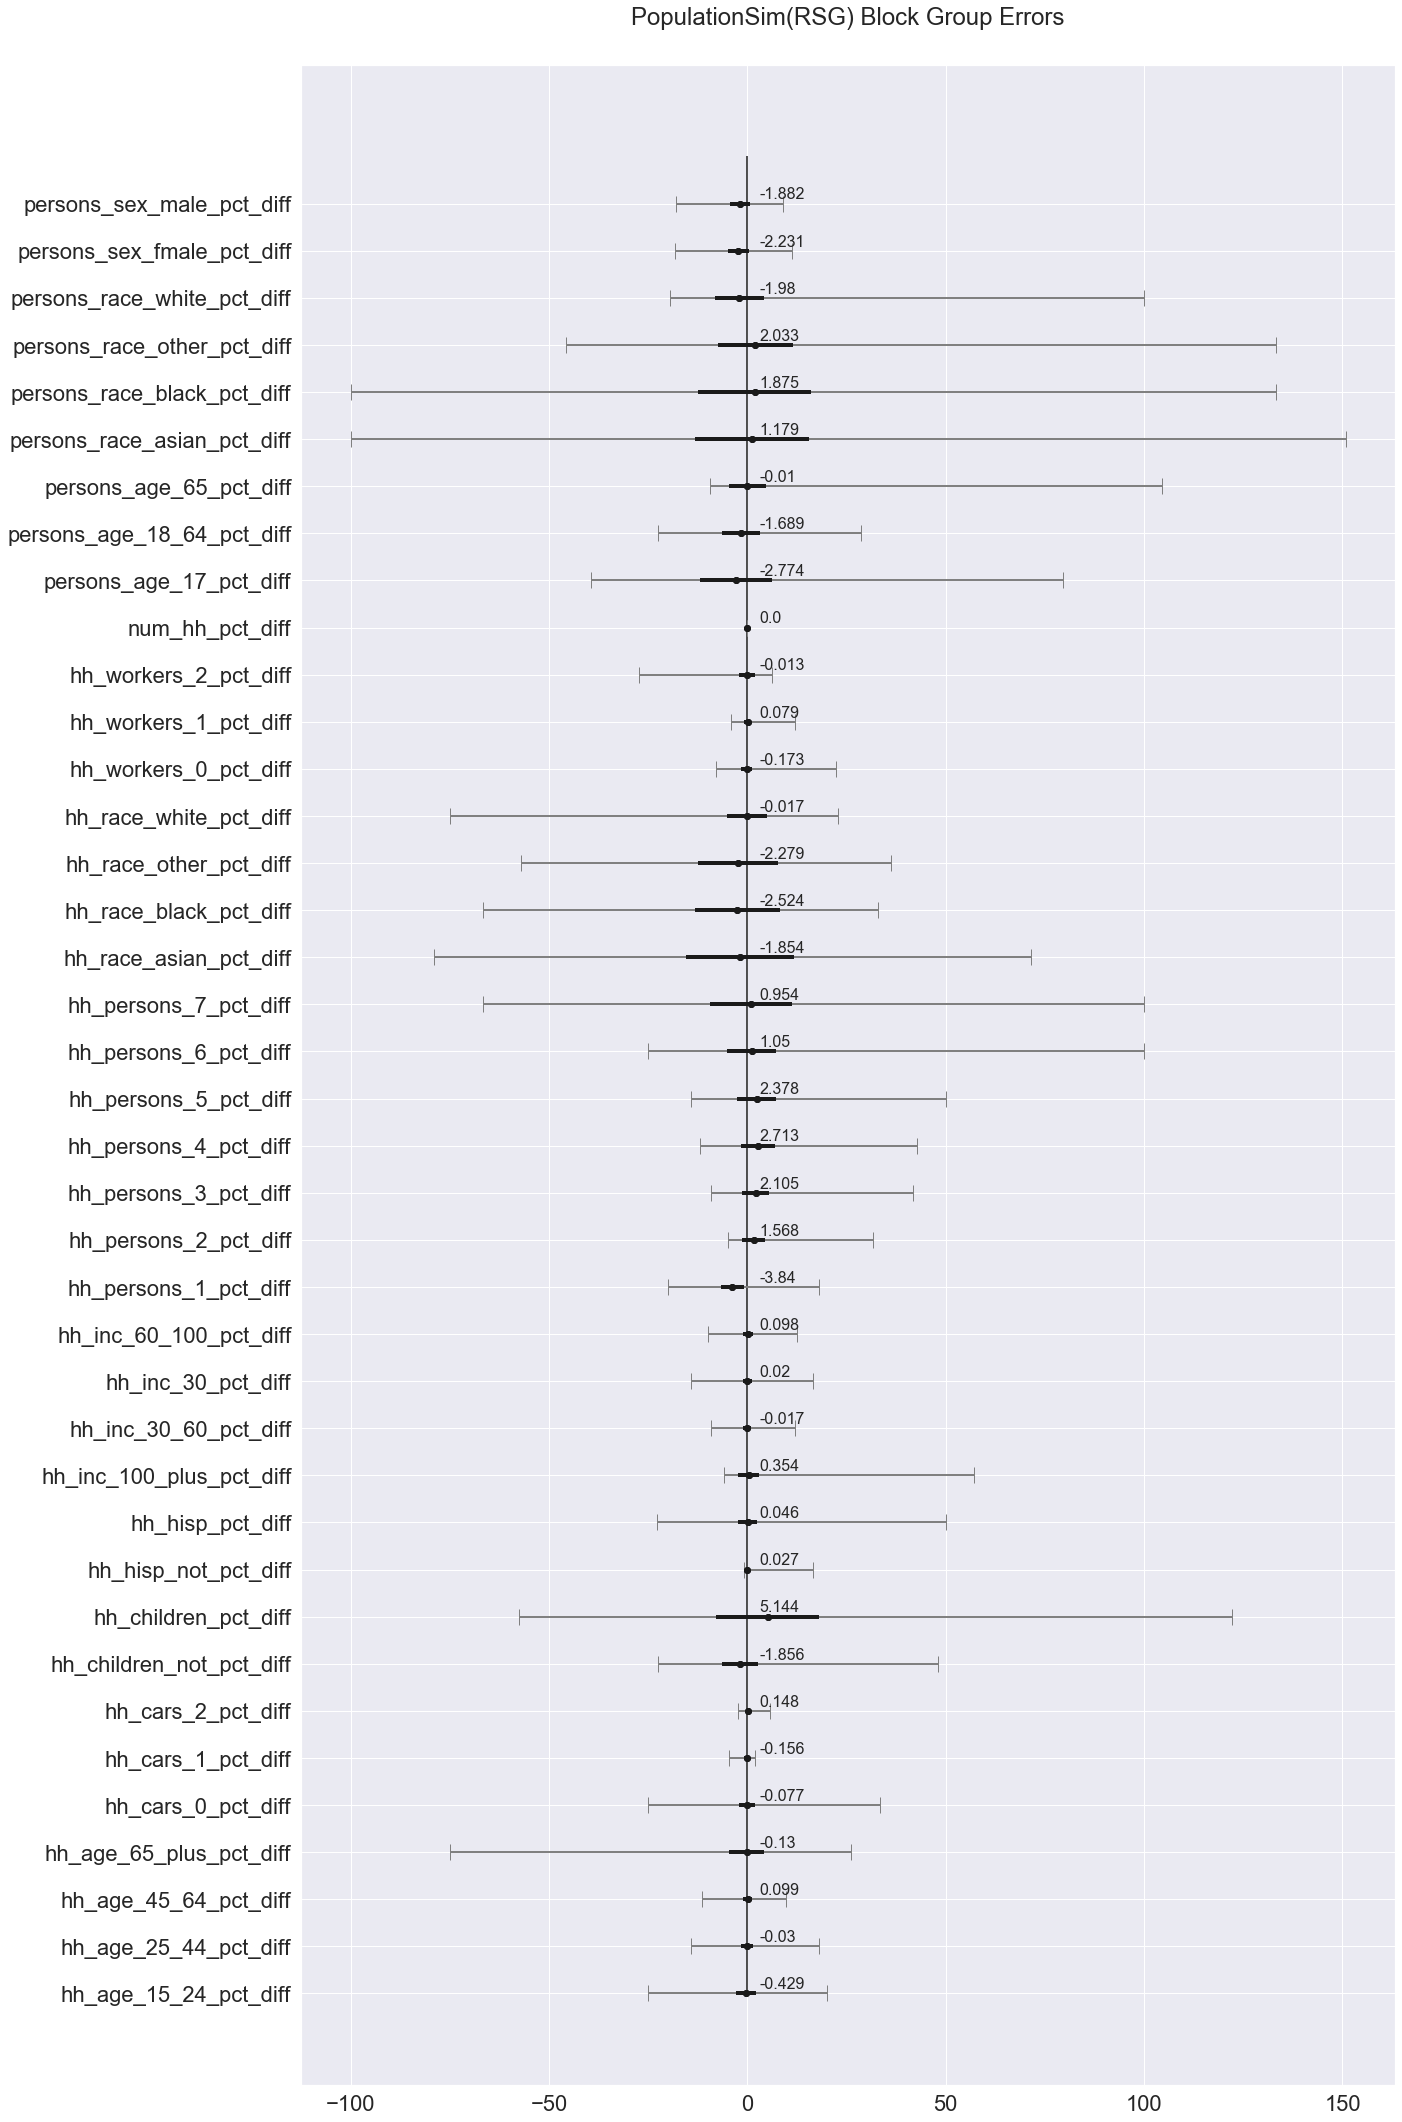

In [18]:
#test vertical
sns.set(font_scale=2)
plt.figure(figsize = (20,30))
plt.rcParams.update({'font.size': 24})
#plt.gca().invert_yaxis()

plt.vlines(0, 0, len(dfp))
plt.errorbar(dfp['mean'], range(len(dfp.index)), xerr= [dfp['mean'] - dfp['min'], dfp['max'] - dfp['mean']],
             fmt='ok', ecolor='gray', lw=2, capsize=8)
plt.errorbar(dfp['mean'], range(len(dfp.index)), xerr=dfp['std'], fmt='ok', lw=4)
for (x,y,l) in zip(dfp['mean'],  range(len(dfp.index)), round(dfp['mean'],3)):
    plt.text(3, y + 0.1, l, size=16)
plt.xticks()
plt.yticks(range(len(dfp.index)), list(dfp.index))
plt.title('PopulationSim(RSG) Block Group Errors', pad=40)

plt.tight_layout()
plt.savefig("_".join([syn, region, geo, 'error.png']))

## Histograms by attributes

In [20]:
import base64
from io import BytesIO
sns.set()

html = """<!DOCTYPE html>  <html>
    <head> <title>%s</title> </head> <body>
""" % "_".join([syn, region, geo, '_histograms'])

for dif in pct_diffs:
    ax = dfs[dif].hist(bins=100, xlabelsize =15, ylabelsize =15, figsize =(9,6))
    fig = ax.get_figure()
    fig.suptitle(dif, fontsize =22 )

    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

    #fig.savefig(dif + '.png')
    fig.clf()

html = html + """</body> </html>"""
with open("_".join([syn, region, geo, '_histograms.html']),'w') as f:
    f.write(html)

<Figure size 648x432 with 0 Axes>

In [ ]:
# plt.figure(figsize = (30,20))
# plt.rcParams.update({'font.size': 22})

# plt.hlines(0, 0, len(dfp))
# plt.errorbar(dfp.index, dfp['mean'], dfp['std'], fmt='ok', lw=4)
# plt.errorbar(dfp.index, dfp['mean'], [dfp['mean'] - dfp['min'], dfp['max'] - dfp['mean']],
#              fmt='.k', ecolor='gray', lw=1, capsize=10 )
# for (x,y,l) in zip(dfp.index, dfp['mean'],  round(dfp['mean'],3)):
#     plt.text(x , y + 0.03, l, rotation='vertical', size = 19, horizontalalignment='right')
# plt.xticks(rotation='vertical')
# plt.yticks(rotation='vertical')
# plt.tight_layout()
# plt.savefig('rsg_oakland.png')

